In [1]:
import osmnx as ox
import geopandas as gpd 
import folium
print(ox.__version__)

/Users/social_todler/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Matplotlib is building the font cache; this may take a moment.


2.0.7


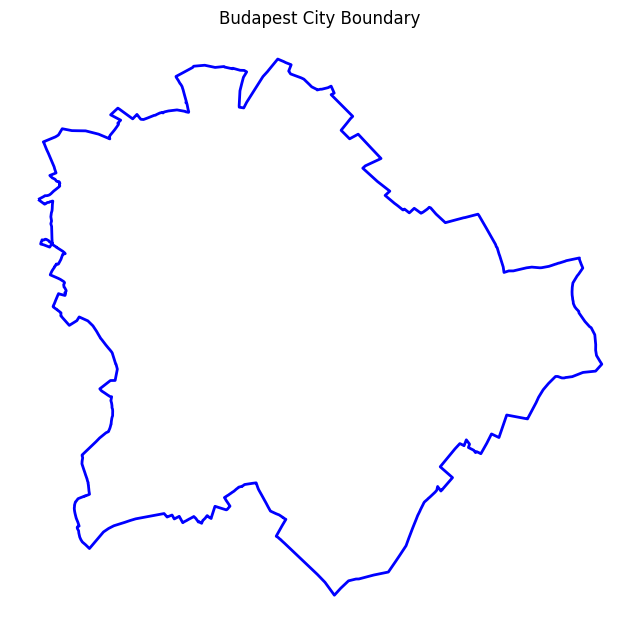

In [5]:
import osmnx as ox
import matplotlib.pyplot as plt

# Correct city-level place name
city_name = "Budapest, Hungary"

# Get administrative boundary as GeoDataFrame
admin = ox.geocode_to_gdf(city_name)

# Plot the city boundary
fig, ax = plt.subplots(figsize=(8, 8))
admin.plot(
    ax=ax,
    facecolor="none",
    edgecolor="blue",
    linewidth=2
)

plt.title("Budapest City Boundary")
plt.axis("off")
plt.show()


In [3]:
%pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


<Axes: >

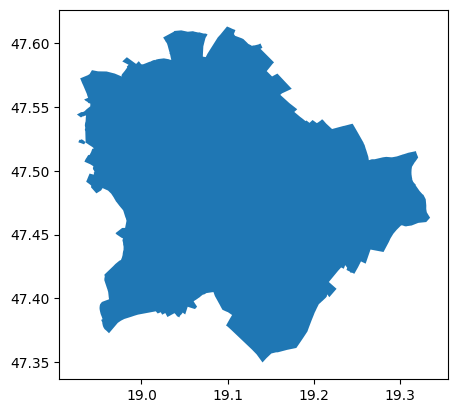

In [8]:
city_name = " Budapest"
admin = ox.geocode_to_gdf(city_name)
admin.plot()

<Axes: >

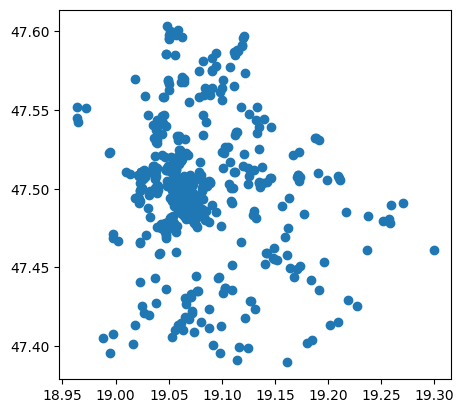

In [17]:
pubs = ox.features_from_place(city_name, {"amenity" :"pub"})
pubs.plot()

In [16]:
pubs = ox.features_from_place(city_name, {"amenity" :"pub"})
sports = ox.features_from_place(city_name, {"leisure" :["gym","sports_centre"]})
healthcare = ox.features_from_place(city_name, {"amenity" :["hospitals","clinics","doctors","pharmacy"]})
print("Pubs:", len(pubs), "| Sports:", len(sports), "| Healthcare:",len(healthcare))



Pubs: 672 | Sports: 317 | Healthcare: 759


In [18]:
def to_points(gdf):
    if gdf. empty:
        return gdf
    return gdf.to_crs(3857).centroid.to_crs(4326).to_frame("geometry")

pubs = to_points(pubs)
sports = to_points(sports)
healthcare = to_points(healthcare)

In [20]:
# Get bounding box from GeoDataFrame
minx, miny, maxx, maxy = admin.total_bounds

# Center of the bounding box (lat, lon)
center = [
    (miny + maxy) / 2,  # latitude
    (minx + maxx) / 2   # longitude
]

# Fit bounds for Folium (southWest, northEast)
fit_bounds = [
    [miny, minx],  # bottom-left (lat, lon)
    [maxy, maxx]   # top-right (lat, lon)
]


In [28]:

# Base map
m = folium.Map(
    location=center,
    zoom_start=11,
    tiles="CartoDB dark_matter",
    control_scale=True
)

# Feature groups
admin_layer = folium.FeatureGroup(name="Admin Boundary", show=True)
pubs_layer = folium.FeatureGroup(name="Pubs", show=True)
sports_layer = folium.FeatureGroup(name="Gyms & Sports", show=True)
healthcare_layer = folium.FeatureGroup(name="Healthcare", show=True)

# Administrative boundary
folium.GeoJson(
    admin,
    style_function=lambda feature: {
        "fillColor": "#ffffff",   # FIX: correct key
        "color": "#ffffff",
        "weight": 3,
        "fillOpacity": 0.15
    }
).add_to(admin_layer)

# Function to add point layers
def add_points(gdf, feature_group, color):
    if gdf is not None and not gdf.empty:
        for _, row in gdf.iterrows():
            geom = row.geometry
            if geom is None:
                continue

            lat, lon = geom.y, geom.x
            folium.CircleMarker(
                location=[lat, lon],
                radius=2,
                weight=0.5,
                fill=True,
                fill_opacity=0.8,
                color=color,
                fill_color=color
            ).add_to(feature_group)

# Add POI layers
add_points(pubs, pubs_layer, "#ff9933")
add_points(sports, sports_layer, "#33ccff")
add_points(healthcare, healthcare_layer, "#ff3333")

# Add layers to map
admin_layer.add_to(m)
pubs_layer.add_to(m)
sports_layer.add_to(m)
healthcare_layer.add_to(m)

# Layer control
folium.LayerControl(collapsed=False, position="topright").add_to(m)

# Fit bounds if available
if fit_bounds:
    m.fit_bounds(fit_bounds)

# Save map
m.save("budapest_pubs.html")

m
